<a href="https://colab.research.google.com/github/Apekshagaonkar/Mujoco-Dynamics-with-ODE_NN/blob/main/notebooks/Walker_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DYNA-Q

In [ ]:
# ! git clone https://github.com/openai/gym.git
# !pip install -e /content/gym
!pip install gym==0.22
!pip install free-mujoco-py
!pip install moviepy==1.0.0
# !pip install tensorboard==2.3.0 tensorboardX==1.8 matplotlib ipython==6.4.0 moviepy==1.0.0 pyvirtualdisplay==1.3.2
!pip install torch
!pip install mujoco
# !pip install opencv-python==4.4.0.42
!pip install ipdb==0.13.3
!pip install ray
!pip install tqdm
! pip install pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708363 sha256=1b4a5fd579cd83a2811d112f690a19ce425d2a21cdba4ad8d4a2073fcd2b84d7
  Stored in directory: /root/.cache/pip/wheels/42/e8/e8/6dfbc92a1dcd76c1a5e2bb982750fd6b7e792239f46039e6b1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Succe

In [ ]:
! git clone https://github.com/nslyubaykin/relax_dyna_q_example.git
! git clone https://github.com/nslyubaykin/relax.git

Cloning into 'relax_dyna_q_example'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 96 (delta 24), reused 4 (delta 0), pack-reused 51
Receiving objects: 100% (96/96), 95.76 MiB | 37.64 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Cloning into 'relax'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 535 (delta 103), reused 79 (delta 42), pack-reused 380
Receiving objects: 100% (535/535), 198.21 KiB | 6.19 MiB/s, done.
Resolving deltas: 100% (333/333), done.


In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [ ]:
%cd /content/relax
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import TD3, RandomUniform
from relax.rl.critics import CDQN
from relax.rl.models import DeltaEnvModel

from relax.zoo.policies import DeterministicMLP
from relax.zoo.critics import ContQMLP
from relax.zoo.models import ContObsContAcsToObsMLP, ContObsContAcsToRewsMLP

from relax.schedules import PiecewiseSchedule, LinearSchedule, CombinedSchedule
from relax.exploration import RandomNormal

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

# from relax.gym.utils import visualize_actor
from relax.gym.terminal_functions import walker2d_v2_terminal_fn

/content/relax


In [ ]:
def get_model(obs_dim, acs_dim,
              terminal_function,
              ensemble_size=7):

    obs_models = []
    rews_models = []
    for i in range(ensemble_size):
        obs_models.append(
            ContObsContAcsToObsMLP(input_obs_dim=obs_dim, output_obs_dim=obs_dim,
                                   acs_dim=acs_dim, nunits=250, nlayers=2) #350 for ant
        )
        rews_models.append(
            ContObsContAcsToRewsMLP(input_obs_dim=obs_dim, acs_dim=acs_dim,
                                    nunits=250, nlayers=2)
        )

    # Creating schedules:
    # first 5000 iterations no learning - just data collection
    model_lr = PiecewiseSchedule({0: 5000}, 1e-3)

    model = DeltaEnvModel(
        obs_models=obs_models,
        device=torch.device('cuda'),
        learning_rate=model_lr,
        noise=0.01,
        batch_size=512,
        rews_models=rews_models,
        terminal_function=terminal_function,
        n_steps_per_update=1,
        update_freq=10,
        stats_recalc_freq=500,
        random_agg=False,
    )

    return model

# Define TD3 actor and CDQN critic

We will also wrap actor and critic definition in  a function to run it in a loop for multiple experiments. That is done in order to benchmark DYNA-Q-TD3 vs vanilla TD3

In [ ]:
def get_actor_and_critic(obs_dim, acs_dim):

    # Creating schedules:
    # first 10000 iterations no learning - just data collection
    policy_lr = PiecewiseSchedule({0: 10000}, 1e-3)
    critic_lr = PiecewiseSchedule({0: 10000}, 1e-3)

    schedule1 = PiecewiseSchedule({0.3: 10000}, 0.0)
    schedule2 = LinearSchedule(0.1, 0, 1000000)
    sigma_schedule = CombinedSchedule(schedule1, schedule2, max)

    # Define exploration
    exploration = RandomNormal(sigma=sigma_schedule,
                               min_acs=-1.0,
                               max_acs=1.0,
                               n_random_steps=10000)

    actor = TD3(
        device=torch.device('cuda'),
        mu_net=DeterministicMLP(obs_dim, acs_dim, out_activation=torch.nn.Tanh()),
        learning_rate=policy_lr,
        batch_size=100,
        min_acs=-1.0,
        max_acs=1.0,
        exploration=exploration,
    )

    critic = CDQN(
        critic_net=ContQMLP(obs_dim, acs_dim),
        critic_net2=ContQMLP(obs_dim, acs_dim),
        device=torch.device('cuda'),
        learning_rate=critic_lr,
        weight_decay=0.0
    )

    return actor, critic


In [ ]:
env_name = 'Walker2d-v2'
terminal_function = walker2d_v2_terminal_fn

acs_dim = 6
obs_dim = 17
n_experiments = 4
n_steps = 1000000


# Load Models

In [ ]:
%cd ..
%cd relax_dyna_q_example


/content
/content/relax_dyna_q_example


In [ ]:

actor, critic = get_actor_and_critic(obs_dim=obs_dim, acs_dim=acs_dim)

# Model
model = get_model(obs_dim=obs_dim, acs_dim=acs_dim,
                  terminal_function=terminal_function,
                  ensemble_size=7)

# provide actor with critic
actor.set_critic(critic)

# setting the schedule for acceleration horizon
horizon_schedule = PiecewiseSchedule({0: 20000}, 1)

# provide actor with model for acceleration
actor.set_acceleration(model=model,
                       actor=RandomUniform(acs_dim=acs_dim,
                                           min_acs=-1,
                                           max_acs=1),
                       h=horizon_schedule,
                       tau=3.0,
                       real_ratio=0.0,
                       train_sampling=True)

# Saving models:
actor.load_checkpoint('trained_models/dyna_q_td3', 'dyna_q_td3_Walker2d-v2_experiment_2_actor')
critic.load_checkpoint('trained_models/dyna_q_td3', 'dyna_q_td3_Walker2d-v2_experiment_2_critic')
model.load_checkpoint('trained_models/dyna_q_td3', 'dyna_q_td3_Walker2d-v2_experiment_2_model')

Loaded checkpoints for TD3...
models_state_dict exploration_global_step global_step local_step n_updates n_target_updates optimizer n_policy_updates
Loaded checkpoints for CDQN...
models_state_dict global_step local_step n_updates n_target_updates optimizer optimizer2
Loaded checkpoints for DeltaEnvModel...
models_state_dict global_step local_step n_updates n_stats_updates n_model_resets updates_per_model obs_optimizer_0 obs_optimizer_1 obs_optimizer_2 obs_optimizer_3 obs_optimizer_4 obs_optimizer_5 obs_optimizer_6 rews_optimizer_0 rews_optimizer_1 rews_optimizer_2 rews_optimizer_3 rews_optimizer_4 rews_optimizer_5 rews_optimizer_6 buffer_stats


# Plot estimated vs actual Q-values

In [ ]:
env_name = 'Walker2d-v2'
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))
eval_sampler = Sampler(env=eval_env)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v3` with the environment ID `Walker2d-v3`.
  logger.warn(


Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

# Visualize trained actor

In [ ]:
import glob
import io
import base64
import numpy as np

from gym.wrappers import Monitor
from gym import Wrapper
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

from relax.data.sampling import Sampler



In [ ]:
def wrap_env(env):
    env = Monitor(env, 'content/video', force=True)
    return env

def show_video_func():
    mp4list = glob.glob('content/video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def set_random_initial_state(smp,incline_angle=0, case_number=1):
    env = smp.env
    env.reset()
    # Assuming the environment is of type 'Walker2d-v3' with specific qpos and qvel attributes
    qpos = env.env.sim.data.qpos
    qvel = env.env.sim.data.qvel
    # print(qpos)
    # print(qvel)

    if case_number == 1:
      qpos[1:2] =  qpos[1:2]+ np.random.uniform(low=-0.005, high=0.005, size=1)  # Randomize root position (excluding x-axis)
      qpos[2:] = qpos[2:] + np.random.uniform(low=-0.005, high=0.005, size=qpos[2:].shape)  # Randomize joint positions
      qvel[:] = qvel[:] + np.random.uniform(low=-0.005, high=0.005, size=qvel.shape)  # Randomize velocities

    if case_number == 2:
      qpos[1:2] =  qpos[1:2]+ np.random.uniform(low=-0.05, high=0.05, size=1)  # Randomize root position (excluding x-axis)
      qpos[2:] = qpos[2:] + np.random.uniform(low=-0.087, high=0.087, size=qpos[2:].shape)  # Randomize joint positions
      qvel[:] = qvel[:] + np.random.uniform(low=-0.05, high=0.05, size=qvel.shape)  # Randomize velocities

    if case_number == 3:
      qpos[1:2] =  qpos[1:2]+ np.random.uniform(low=-0.1, high=0.1, size=1)  # Randomize root position (excluding x-axis)
      qpos[2:] = qpos[2:] + np.random.uniform(low=-0.17, high=0.17, size=qpos[2:].shape)  # Randomize joint positions
      qvel[:] = qvel[:] + np.random.uniform(low=-0.1, high=0.1, size=qvel.shape)  # Randomize velocities

    if case_number == 4:
      qpos[1:2] =  qpos[1:2]+ np.random.uniform(low=-0.15, high=0.15, size=1)  # Randomize root position (excluding x-axis)
      qpos[2:] = qpos[2:] + np.random.uniform(low=-0.26, high=0.26, size=qpos[2:].shape)  # Randomize joint positions
      qvel[:] = qvel[:] + np.random.uniform(low=-0.1, high=0.1, size=qvel.shape)  # Randomize velocities

    # print(qpos)
    # print(qvel)

    # env.env.set_state(qpos, qvel)
    ob = np.concatenate([qpos[1:], qvel])  # Exclude the first dimension (x-axis) of qpos
    smp.add_obs(ob)

    # Set the inclination of the plane
    model = env.env.model
    model.opt.gravity[0] = 9.81 * np.sin(incline_angle)  # Adjust gravity for inclination
    model.opt.gravity[2] = -9.81 * np.cos(incline_angle)

    return ob

def apply_inclination_visual(frame, incline_angle):
    """
    Apply visual indication of inclination to the frame.
    This function adds a rotated rectangle or other visual markers to indicate the incline.
    """
    import cv2
    h, w, _ = frame.shape
    overlay = frame.copy()
    angle_degrees = np.degrees(incline_angle)

    # Draw a tilted line or rectangle to indicate the incline
    rect_center = (w // 2, h // 2)
    rect_size = (w, h // 10)
    rect = ((rect_center), rect_size, angle_degrees)

    box = cv2.boxPoints(rect)
    box = np.intp(box)  # Use np.intp instead of np.int0
    cv2.drawContours(overlay, [box], 0, (0, 255, 0), -1)

    # Blend the overlay with the original frame
    alpha = 0.4  # Transparency factor
    frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    return frame

In [ ]:
test_env = wrap_env(eval_env)
test_env.seed(0)

obs_nlags = 0
obs_concat_axis = -1
obs_expand_axis = None
obs_padding = 'first'

if hasattr(actor, 'obs_nlags'):
    obs_nlags = actor.obs_nlags
if hasattr(actor, 'obs_concat_axis'):
    obs_concat_axis = actor.obs_concat_axis
if hasattr(actor, 'obs_expand_axis'):
    obs_expand_axis = actor.obs_expand_axis
if hasattr(actor, 'obs_padding'):
    obs_padding = actor.obs_padding

smp = Sampler(env=test_env,
              obs_nlags=obs_nlags,
              obs_concat_axis=obs_concat_axis,
              obs_expand_axis=obs_expand_axis,
              obs_padding=obs_padding)


In [ ]:
def visualize_actor(actor, env, nsteps=200, size=(1400, 900), seed=0, train_sampling=False, data=None, incline_angle=0, case_number = 1, show_video=False, generate=True):
    # display = Display(visible=0, size=size)
    # display.start()

    # test_env = wrap_env(env)
    test_env.seed(seed)

    # obs_nlags = getattr(actor, 'obs_nlags', 0)
    # obs_concat_axis = getattr(actor, 'obs_concat_axis', -1)
    # obs_expand_axis = getattr(actor, 'obs_expand_axis', None)
    # obs_padding = getattr(actor, 'obs_padding', 'first')

    # smp = Sampler(env=test_env, obs_nlags=obs_nlags, obs_concat_axis=obs_concat_axis, obs_expand_axis=obs_expand_axis, obs_padding=obs_padding)

    # previous_mode = actor.train_sampling
    # actor.train_sampling = train_sampling

    ob = set_random_initial_state(smp, incline_angle=incline_angle,case_number=case_number)
    if show_video:
      frames = []

    for i in range(nsteps):
        if show_video:
          frame = test_env.render(mode='rgb_array')
          frames.append(frame)
        smp.add_obs(ob)
        _ob = smp.get_obs()
        _ob = np.expand_dims(_ob, axis=0) # put _ob into batchmode for consistency
        ac = actor.get_action(_ob)
        ac = ac.squeeze(axis=0) # squeeze ac back for storage
        if generate:
            qpos = env.env.sim.data.qpos
            qvel = env.env.sim.data.qvel
            data[seed, i, :] = np.concatenate([qpos, qvel]) # 18 enteries

        ob, rew, done, info = smp.step_env(ac)
        # tot_rew += rew
        # print(i)
        if done:
            break

    test_env.close()
    # actor.train_sampling = previous_mode
    if show_video:
        print('Loading video...')
        for frame in frames:
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            ipythondisplay.clear_output(wait=True)
        # show_video_fn()

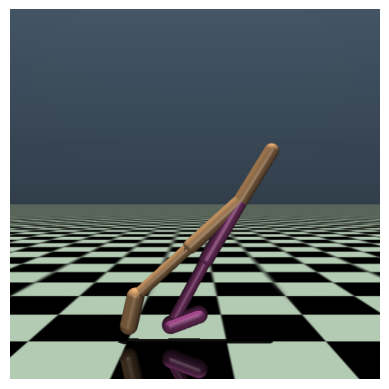

In [ ]:
# data = np.zeros((10, 200, 18))
# visualize_actor(actor=actor, env=eval_env, nsteps=200, train_sampling=False, data=data, seed=0, incline_angle=0, case_number = 1, show_video=True, generate=True)

# # Save the data to a file
# %cd /content/
# filename = f'training_test.pt'
# torch.save(data, filename)

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipythondisplay
from moviepy.editor import ImageSequenceClip

def visualize_data(actor, env, nsteps=200, size=(1400, 900), seed=0, train_sampling=False, data=None, incline_angle=0, show_video=False, generate=False):
    display = Display(visible=0, size=size)
    display.start()

    test_env = wrap_env(env)
    test_env.seed(seed)

    obs_nlags = getattr(actor, 'obs_nlags', 0)
    obs_concat_axis = getattr(actor, 'obs_concat_axis', -1)
    obs_expand_axis = getattr(actor, 'obs_expand_axis', None)
    obs_padding = getattr(actor, 'obs_padding', 'first')

    smp = Sampler(env=test_env, obs_nlags=obs_nlags, obs_concat_axis=obs_concat_axis, obs_expand_axis=obs_expand_axis, obs_padding=obs_padding)

    previous_mode = actor.train_sampling
    actor.train_sampling = train_sampling

    ob = test_env.reset()

    tot_rew = 0
    frames = []

    for i in range(nsteps):
      ob = data[i, :]
      qpos = env.env.sim.data.qpos.copy()
      qvel = env.env.sim.data.qvel.copy()

      qpos[:] = data[i, :9]
      qvel[:] = data[i, 9:]
      env.env.set_state(qpos, qvel)

      frame = test_env.render(mode='rgb_array')
      frames.append(frame)

    test_env.close()
    actor.train_sampling = previous_mode
    if show_video:
        print('Loading video...')
        for frame in frames:
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            ipythondisplay.clear_output(wait=True)
        clip = ImageSequenceClip(frames, fps=30)
        clip.write_videofile(f"/content/walker_trajectory{seed}.mp4")
        print("Video saved successfully.")

In [ ]:
# # To visualize the generated data:
# loaded_data = torch.load('/content/training_test.pt')
# visualize_data(actor=actor, env=eval_env, nsteps=200, train_sampling=False, data=loaded_data[0], seed=0, incline_angle=0, show_video=True, generate=False)


Moviepy - Building video /content/walker_trajectory0.mp4.
Moviepy - Writing video /content/walker_trajectory0.mp4



Moviepy - Done !
Moviepy - video ready /content/walker_trajectory0.mp4
Video saved successfully.


In [ ]:
# Define the parameters
import numpy as np

nsteps = 200
data_dim = 18

case_numbers = [1, 2, 3, 4]

n_samples_0 = [250, 250, 250, 250, 250]
n_samples_5 = [250, 500, 1000, 500, 500]
n_samples_10 = [1000, 1000, 1000, 1000]
n_samples_15 = [1000, 500, 500]

# n_samples_0 = [2, 3, 4, 4, 2]
# n_samples_5 = [1,2,3,2,1]
# n_samples_10 = [2,1,3,1]
# n_samples_15 = [3,1,2]

n_samples = [n_samples_0, n_samples_5, n_samples_10, n_samples_15]

incline_angles_0 = [0, 0.087, 0.17, 0.26, 0.35]
incline_angles_5 = [0, 0.087, 0.17, 0.26, 0.35]
incline_angles_10 = [0, 0.087, 0.17, 0.26]
incline_angles_15 = [0, 0.087, 0.17]

incline_angles = [incline_angles_0, incline_angles_5, incline_angles_10, incline_angles_15]

data_final = []

# Iterate over the inclination angles and corresponding sample sizes
for case_index, case_number in enumerate(case_numbers):
  print('case number', case_number)
  for angle_index, incline_angle in enumerate(incline_angles[case_index]):
      print('incline angle', incline_angle)
      # Run the simulation for each sample
      data = np.zeros((n_samples[case_index][angle_index], nsteps, data_dim))
      for i in range(n_samples[case_index][angle_index]):
          # Initialize the data array
          # visualize_actor(smp=smp, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=incline_angle,case_number = case_number, show_video=False)
          visualize_actor(actor=actor, env=eval_env, nsteps=nsteps, train_sampling=False, data=data, seed=i, incline_angle=incline_angle,case_number = case_number, show_video=False, generate=True)

      data_final.append(data)

data_final = np.concatenate(data_final, axis=0)

# Save the data to a file
%cd /content/
filename = f'training.pt'
torch.save(data_final, filename)

# print(f'Data for inclination angle {incline_angle} saved to {filename}')


case number 1
incline angle 0
incline angle 0.087
incline angle 0.17
incline angle 0.26
incline angle 0.35
case number 2
incline angle 0
incline angle 0.087
incline angle 0.17
incline angle 0.26
incline angle 0.35
case number 3
incline angle 0
incline angle 0.087
incline angle 0.17
incline angle 0.26
case number 4
incline angle 0
incline angle 0.087
incline angle 0.17
/content


In [ ]:
# visualize_data(actor=actor, env=eval_env, nsteps=200, train_sampling=False, data=data_final[35], seed=35, incline_angle=0, show_video=True, generate=False)


Moviepy - Building video /content/walker_trajectory35.mp4.
Moviepy - Writing video /content/walker_trajectory35.mp4



Moviepy - Done !
Moviepy - video ready /content/walker_trajectory35.mp4
Video saved successfully.


In [ ]:
ls

content/  relax_dyna_q_example/  training.pt       walker_trajectory0.mp4   walker_trajectory35.mp4
relax/    sample_data/           training_test.pt  walker_trajectory34.mp4  walker_trajectory36.mp4


In [ ]:
data = torch.load('/content/training.pt')
np.array(data).shape

shuffled_indices = torch.randperm(data.shape[0])
shuffled_data = data[shuffled_indices]

torch.save(shuffled_data, '/content/training_shuffled.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp 'training.pt' '/content/drive/My Drive/training.pt'

In [ ]:
!cp 'training_shuffled.pt' '/content/drive/My Drive/training_shuffled.pt'

In [ ]:
# n_samples = 3
# nsteps = 200
# data_dim = 17

# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=0.26,show_video=True)

# %cd /content/
# torch.save(data,'training.pt')

In [ ]:
# n_samples = 1
# nsteps = 300
# data_dim = 17
# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=1.1,show_video=True)


In [ ]:
# n_samples = 5
# nsteps = 200
# data_dim = 17
# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=1,show_video=True)


In [ ]:
# n_samples = 5
# nsteps = 200
# data_dim = 17
# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=2,show_video=True)

In [ ]:
# n_samples = 5
# nsteps = 200
# data_dim = 17
# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=0.5,show_video=True)

In [ ]:
# n_samples = 5
# nsteps = 200
# data_dim = 17
# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=0.1,show_video=True)

In [ ]:
# n_samples = 5
# nsteps = 200
# data_dim = 17
# data = np.zeros((n_samples, nsteps, data_dim))
# for i in range(n_samples) :
#   visualize_actor(env=eval_env, actor=actor, nsteps=nsteps, train_sampling=False,data= data, seed=i,incline_angle=30,show_video=True)

In [ ]:
# <!-- Example snippet of the XML file -->
# <mujoco>
#   <worldbody>
#     <!-- Existing ground plane definition -->
#     <geom name="floor" type="plane" pos="0 0 0" size="40 40 1" />

#     <!-- Modified ground plane definition with a slope -->
#     <geom name="floor" type="plane" pos="0 0 0" size="40 40 1" euler="0.1 0 0" />
#   </worldbody>
# </mujoco>

In [ ]:
# %cd /content/gym

In [ ]:
# !pip install -e .

In [ ]:
# !cat /content/gym/gym/envs/mujoco/assets/walker2d.xml

In [ ]:
# !pip uninstall gym -y